In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

Load the dataset which contains 8 columns and then I normalized the data using the mean and standard deviation

In [2]:
df = pd.read_csv("HTRU_2.csv")
df = (df - np.mean(df, axis=0)) / np.std(df, axis=0)

In [3]:
df = df.to_numpy()
df

array([[ 1.14931702,  1.33483164, -0.66956953, ..., -0.37062547,
        -0.07279778, -0.28743812],
       [-0.3341682 ,  1.80226533, -0.01178476, ..., -0.5889241 ,
         0.50442694,  0.21158145],
       [-0.31437216, -1.05332222, -0.14523256, ..., -0.23532816,
        -0.12599609, -0.39137346],
       ...,
       [ 0.3218423 ,  1.95621968, -0.2993338 , ...,  1.67156847,
        -1.28807874, -0.94133005],
       [ 0.13362759,  1.07450972, -0.26005007, ..., -0.66485697,
         0.37825656,  0.27584987],
       [-2.10576204,  5.73546965,  0.87267394, ...,  1.97154554,
        -2.19732744, -0.97105168]])

Create a class for the custom Kmeans clustering. This is a very simple algorithm which randomly selects datapoints from the data as initial centroids and then iteratively finds the euclidean distance of each datapoint to the centroid. Then, the datapoints are put into groups based on its distance to the centroids and then again the centroids are updated based on the current datapoints in the cluster. The algorithm runs until there is no change to the current centroids.

In [4]:
class KMeans_custom():
    def __init__(self,k,epochs,e):
        self.k = k
        self.epochs = epochs
        self.e = e
        
    def euclidean_distance(self,x1, x2):
        return np.sqrt(np.sum((x1 - x2)**2))

    def fit(self,x):
        mu_old = x[np.random.choice(x.shape[0],self.k,replace=False),:]
        mu = x[np.random.choice(x.shape[0],self.k,replace=False),:]
        d = np.zeros((x.shape[0],mu.shape[0]))
        for _ in range(self.epochs):
            for i,mu_row in enumerate(mu_old):
                d[:,i] = np.apply_along_axis(lambda r: self.euclidean_distance(r,mu_row),1,x)
            cluster = np.argmin(d,axis=1)
            if((1/self.k)*abs(np.sum(mu-mu_old))<self.e):
                break
            else:
                for j in range(mu.shape[0]):    
                    mu[i,:] = np.mean(x[cluster==j, :], axis=0)
                mu_old = mu.copy()
        return mu,cluster

    def PCA(self,X,k):
        uni,sing,_ = np.linalg.svd(X,full_matrices=False)
        uni = uni[:,:k]
        sing = sing[:k]

        proj = uni@np.diag(sing)
        return proj


In [5]:
km = KMeans_custom(k=2,epochs=200,e=10e-6)
centroid,cluster = km.fit(df)

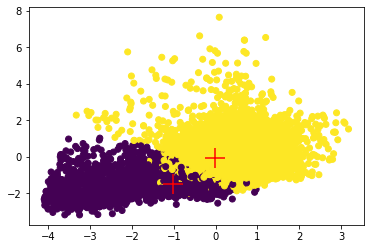

In [6]:
plt.scatter(df[:, 0], df[:, 1], c=cluster)
plt.scatter(centroid[:, 0], centroid[:, 1], marker='+', s=400,color='r')
plt.show()

(17898,)


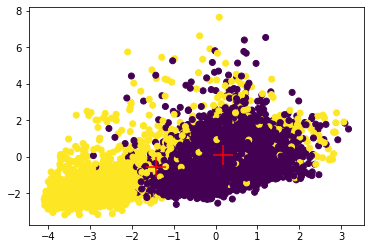

In [7]:
kmeans = KMeans(n_clusters=2,max_iter=200)

labels = kmeans.fit_predict(df)
centroids = kmeans.cluster_centers_

print(labels.shape)

plt.scatter(df[:, 0], df[:, 1], c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='+', s=400, color='r')
plt.show()

I have used the svd function of numpy to find the projection of the values for each of the columns of the data. These projections can be used as the reduced features of the data. Here I have used 2 components. To compare the performance of the defined algorithm, I have compared the clusters obtained from the ddefined functions with the one available in sklearn. The results seem to be comparable.

In [8]:
km1 = KMeans_custom(k=2,epochs=200,e=10e-6)
p = km1.PCA(df,2)
centroid1,cluster1 = km1.fit(p)

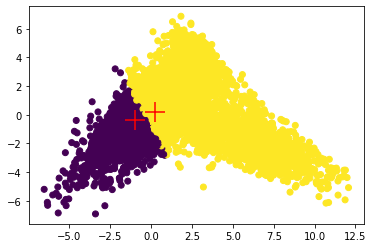

In [9]:
plt.scatter(p[:, 0], p[:, 1], c=cluster1)
plt.scatter(centroid1[:, 0], centroid1[:, 1], marker='+', s=400,color='r')
plt.show()

In [10]:
pca1 = PCA(n_components=2,svd_solver='full')
kmeans1 = KMeans(n_clusters=2,max_iter=200)

p_sklearn = pca1.fit_transform(df)
labels1 = kmeans1.fit_predict(p_sklearn)
centroids1 = kmeans1.cluster_centers_


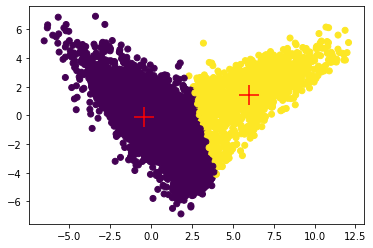

In [11]:
plt.scatter(p_sklearn[:, 0], p_sklearn[:, 1], c=labels1)
plt.scatter(centroids1[:, 0], centroids1[:, 1], marker='+', s=400, color='r')
plt.show()

### 2. Gaussian Mixtures

The Gaussian mixture here uses two steps: first the responsibilities are calculated using the multivariate normal distribution function and then based on it the coefficients of the EM algorithms are updated in the maximization step. I have implemented the algorithm used by the author from the link provided in reference. 

In [238]:
class GMM():
    def __init__(self, k, epochs):
        self.k = k
        self.epochs = epochs
 
    def expectation(self,X,mu,sigma,pi,r):
        for i in range(X.shape[0]):
            for j in range(self.k):
                r[i, j] = pi[j] * self.mul_normal_func(X[i], mu[j], sigma[j])
                r[i,j] /= np.sum([pi[l]*self.mul_normal_func(X[i], mu[l], sigma[l]) for l in range(self.k)])
        return r
    
    def maximization(self,X,mu,sigma,pi,r):
        Nk = np.sum(r, axis=0)
        for j in range(self.k):
            for n in range(X.shape[0]):
                mu[j] += (1/Nk)*r[n, j] * X[n]
            #mu = [(1/Nk)*mu[l] for l in range(self.k)]
            sigma[j] = np.dot(r[n, j] * (X[n] - mu[j]).T, (X[n] - mu[j])) / Nk[j]
            pi[j] = Nk[j] / len(X)
        return mu,sigma,pi
        
    def fit(self, X):
        mu = X[np.random.choice(X.shape[0],self.k,replace=False),:]
        sigma = np.zeros((self.k, X.shape[1], X.shape[1]))
        pi = np.zeros(self.k)
        pi_old = pi.copy()
        r = np.zeros((X.shape[0], self.k))
        for i in range(self.k):
            sigma[i] = np.cov(X.T)
            pi[i] = 1 / self.k
        for _ in range(self.epochs):
            r = self.expectation(X,mu,sigma,pi,r)
            print(r.shape)
            mu,sigma,pi = self.maximization(X,mu,sigma,pi,r) 
            if np.linalg.norm(pi - pi_old) < 10e-3:
                break
            pi_old = pi.copy()
        mu = np.asarray(mu)
        return r,mu,sigma
    
    def predict(self, r):
        return r.argmax(axis=1)
    
    def mul_normal_func(self, X, mu, sigma):
        denominator = np.sqrt((2*np.pi)**(-len(X)/2)*np.linalg.det(sigma))
        numerator = np.exp(-np.dot(np.dot((X-mu).T, np.linalg.inv(sigma)), (X-mu))/2)
        return numerator*denominator
    
    def PCA(self,r,k):
        uni,sing,_ = np.linalg.svd(r,full_matrices=False)
        uni = uni[:,:k]
        sing = sing[:k]

        proj = uni@np.diag(sing)
        return proj


I implemented using 8 clusters. and then later using the PCA, i reduced the dimensionality to 2 componenets and then used the GMM clustering to generate two clusters.

In [254]:
gmm = GMM(8,200)
#df_norm = df[:,:2]
r,mu,sigma = gmm.fit(df)

(17898, 8)


In [255]:
label_n = gmm.predict(df)

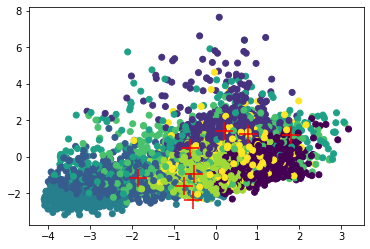

In [256]:
plt.scatter(df[:,0],df[:,1],c=label_n)
plt.scatter(mu[:,0],mu[:,1],s=300,marker='+',c='red')
plt.show()

In [251]:
gmm1 = GMM(2,200)
df1 = gmm1.PCA(df,2)
r1,mu1,sigma = gmm1.fit(df1)

(17898, 2)


In [252]:
label1 = gmm1.predict(df1)

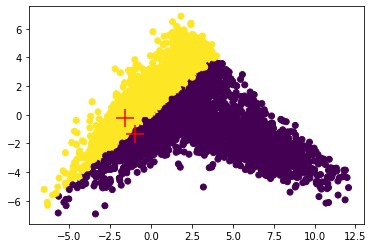

In [253]:
plt.scatter(df1[:,0],df1[:,1],c=label1)
plt.scatter(mu1[:,0],mu1[:,1],s=300,marker='+',c='red')
plt.show()

### References
1. https://www.samlau.me/test-textbook/ch/19/pca_svd.html
2. https://towardsdatascience.com/gaussian-mixture-models-implemented-from-scratch-1857e40ea566
3. https://www.kaggle.com/code/adinishad/kmeans-clustering-from-scratch